<a href="https://colab.research.google.com/github/Taketo-Muroya/Adv-ML/blob/master/Assignment_2_image_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Assignment #2: Write up a report that makes use of brain tumor diagnostic MRI image data

* Visualize brain tumor images that demonstrate when images have tumors and when they do not have tumors.
* Discuss why building a predictive model using this data might be practically useful.  Who could benefit from a model like this? Explain.
* Run at least three prediction models to try to predict brain tumor MRI images well.
 * Use transfer learning for at least one of these models
 * Discuss which models performed better and point out relevant hyper-parameter values for successful models.
* Submit your best model to the leader board for the Brain Tumor Diagnostic AI Model Share competition.
* Import the best model from the leader board (whatever the best model is after your final submission)
 * Note: Import the model's config and it's optimization config.
 * Visualize the model's structure using tf.kera's model.summary() 
 * Explain how the model's structure is different from your best model.
 * Explain how the model's optimization approach is different from your best model
* Fit the best model from the leader board to training data and evaluate it on test data to complete your report.

My GitHub page:
https://github.com/Taketo-Muroya/Adv-ML/blob/master/Assignment_2_image_CNN.ipynb

In [0]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications  import VGG19, ResNet50, InceptionV3 

In [0]:
!unzip brain_tumor_dataset.zip

In [49]:
# Extracting all filenames iteratively from brain_tumor_dataset folder
base_path = 'brain_tumor_dataset'
categories = ['yes', 'no']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [155, 98]
[['brain_tumor_dataset/yes/Y98.JPG', 'brain_tumor_dataset/yes/Y76.jpg', 'brain_tumor_dataset/yes/Y38.jpg', 'brain_tumor_dataset/yes/Y253.JPG', 'brain_tumor_dataset/yes/Y108.jpg', 'brain_tumor_dataset/yes/Y11.jpg', 'brain_tumor_dataset/yes/Y20.jpg', 'brain_tumor_dataset/yes/Y82.jpg', 'brain_tumor_dataset/yes/Y153.jpg', 'brain_tumor_dataset/yes/Y3.jpg', 'brain_tumor_dataset/yes/Y44.JPG', 'brain_tumor_dataset/yes/Y257.jpg', 'brain_tumor_dataset/yes/Y29.jpg', 'brain_tumor_dataset/yes/Y22.jpg', 'brain_tumor_dataset/yes/Y168.jpg', 'brain_tumor_dataset/yes/Y14.jpg', 'brain_tumor_dataset/yes/Y112.JPG', 'brain_tumor_dataset/yes/Y113.JPG', 'brain_tumor_dataset/yes/Y103.jpg', 'brain_tumor_dataset/yes/Y34.jpg', 'brain_tumor_dataset/yes/Y104.jpg', 'brain_tumor_dataset/yes/Y249.JPG', 'brain_tumor_dataset/yes/Y1.jpg', 'brain_tumor_dataset/yes/Y120.JPG', 'brain_tumor_dataset/yes/Y187.jpg', 'brain_tumor_dataset/yes/Y156.JPG', 'brain_tumor_dataset/yes/Y116.J

In [50]:
# Let's explore the details of the image data using load_img from keras
from keras.preprocessing import image
from keras.preprocessing.image import load_img
import numpy as np
from PIL import Image

img = load_img('brain_tumor_dataset/yes/Y26.jpg')
# report details about the image
print(type(img))
print(img.format)
print(img.mode)
print(img.size)

# It's an RGB image, so we can import using the following approach.

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
RGB
(628, 630)


In [0]:
# Import image, load to array of shape height, width, channels, then min/max transform.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def load_image(img_path):
        img = Image.open(img_path).convert("RGB").resize((224,224)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-np.float32(img).min())/(np.float32(img).max()-np.float32(img).min()) # min max transformation
        img=img.reshape((224,224,3)) # Create final shape as array with correct dimensions for Keras
        return img

# read in all images from filenames

preprocessed_image_data=list(map(load_image, fnames[0]+fnames[1])) 

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model


In [52]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape

253
(224, 224, 3)
0.0
1.0


(253, 224, 224, 3)

In [53]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

yes=list(repeat("yes", 155))
no=list(repeat("no", 98))

#combine into single list of y labels
y_labels = yes+no

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas
import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

253


,no,yes
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
248,1,0
249,1,0
250,1,0
251,1,0


##Visualize brain tumor images that demonstrate when images have tumors and when they do not

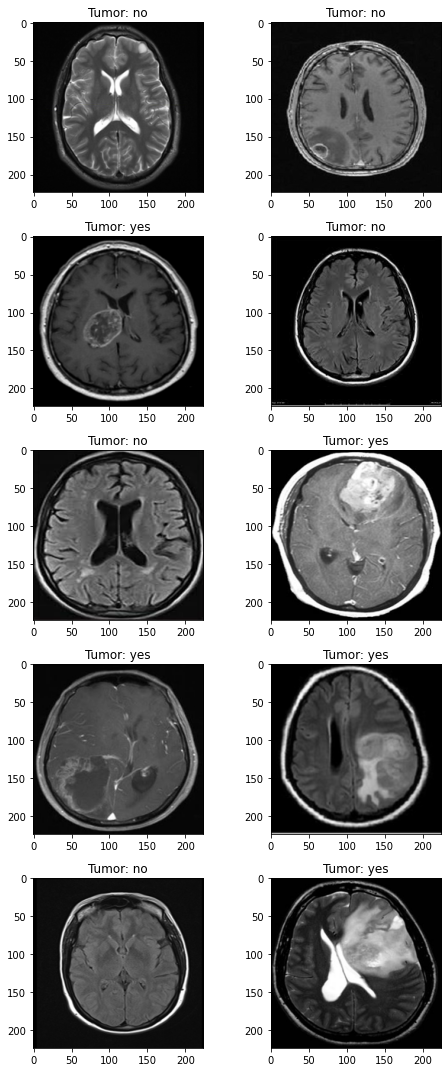

In [107]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(7,15)
for i in range(5):
    for j in range (2):
        l= np.random.randint(0,len(y_labels))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Tumor: '+y_labels[l])
        
plt.tight_layout()

##Discuss why building a predictive model using this data might be practically useful

**Answers:**

 * The doctors who deal with brain tumors could benefit from the model because the machine could detect brain tumors automatically.
 * Although trained doctors would find brain tumors by their eyes almost perfectly, the machine could serve as the double-check system.
 * If the machine was trained very well with many images, it might detect even tiny brain tumors that doctors might not find by their eyes.

##Run at least three prediction models to try to predict brain tumor MRI images well
* Use transfer learning for at least one of these models
* Discuss which models performed better and point out relevant hyper-parameter values for successful models

In [54]:
# Train test split resized images
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)
y_train 

,no,yes
38,0,1
143,0,1
84,0,1
55,0,1
217,1,0
...,...,...
106,0,1
14,0,1
92,0,1
179,1,0


**1. Baseline plain vanilla network model**

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(128, input_shape=(224, 224, 3), activation='relu'))
      model.add(Dense(128, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(2, activation='softmax'))

      # evaluating val_acc maximization
      mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
      # dividing lr by 10 when val_accuracy fails to improve after 3 epochs
      red_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.0001)                                              
      
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
      # Fitting the NN to the Training set
      model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test)) # callbacks=[mc,red_lr])

Epoch 1/10
7/7 [==============================] - 3s 426ms/step - loss: 0.6690 - accuracy: 0.5446 - val_loss: 0.6276 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 3s 405ms/step - loss: 0.5675 - accuracy: 0.6634 - val_loss: 0.6923 - val_accuracy: 0.5294
Epoch 3/10
7/7 [==============================] - 3s 407ms/step - loss: 0.5565 - accuracy: 0.7129 - val_loss: 0.5665 - val_accuracy: 0.7451
Epoch 4/10
7/7 [==============================] - 3s 405ms/step - loss: 0.5127 - accuracy: 0.7921 - val_loss: 0.7553 - val_accuracy: 0.5294
Epoch 5/10
7/7 [==============================] - 3s 405ms/step - loss: 0.4992 - accuracy: 0.7673 - val_loss: 0.5239 - val_accuracy: 0.7647
Epoch 6/10
7/7 [==============================] - 3s 406ms/step - loss: 0.4713 - accuracy: 0.8119 - val_loss: 0.5308 - val_accuracy: 0.6863
Epoch 7/10
7/7 [==============================] - 3s 406ms/step - loss: 0.4631 - accuracy: 0.7921 - val_loss: 0.5129 - val_accuracy: 0.7647
Epoch 8/10
7/7 [====

The plain vanilla network model works not bad for this case. But since this dataset is image data, CNN should be better model.

**2. Convolutional Neural Network**

In [25]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

   model = tf.keras.Sequential([
      # input: images of size 192x192x3 pixels (the three stands for RGB channels)
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=[224, 224, 3]),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=2),
      tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=1, filters=8,  padding='same', activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(2, activation='softmax')
    ])

    #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
    #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) 
    #dividing lr by 10 when val_accuracy fails to improve after 3 epochs

   model.compile(
      optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
      loss= 'categorical_crossentropy',
      metrics=['accuracy'])
    
   # Fitting the CNN to the Training set
   model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test)) #callbacks=[red_lr]) 

Epoch 1/10
7/7 [==============================] - 1s 198ms/step - loss: 0.6539 - accuracy: 0.6535 - val_loss: 0.7003 - val_accuracy: 0.5294
Epoch 2/10
7/7 [==============================] - 1s 90ms/step - loss: 0.6165 - accuracy: 0.6337 - val_loss: 0.6330 - val_accuracy: 0.5294
Epoch 3/10
7/7 [==============================] - 1s 89ms/step - loss: 0.5849 - accuracy: 0.6535 - val_loss: 0.5798 - val_accuracy: 0.5882
Epoch 4/10
7/7 [==============================] - 1s 89ms/step - loss: 0.5743 - accuracy: 0.7376 - val_loss: 0.4635 - val_accuracy: 0.7647
Epoch 5/10
7/7 [==============================] - 1s 89ms/step - loss: 0.5415 - accuracy: 0.7327 - val_loss: 0.4951 - val_accuracy: 0.7843
Epoch 6/10
7/7 [==============================] - 1s 88ms/step - loss: 0.5385 - accuracy: 0.7525 - val_loss: 0.4593 - val_accuracy: 0.7647
Epoch 7/10
7/7 [==============================] - 1s 89ms/step - loss: 0.4939 - accuracy: 0.7673 - val_loss: 0.5171 - val_accuracy: 0.7843
Epoch 8/10
7/7 [==========

The typical CNN model works better than the plain vanilla model. The number of layers seems to matter.

**3. VGG19 (CNN Transfer Learning)**

In [26]:
# example of loading the vgg19 model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

# load model new input layer shape
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model VGG19
base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [27]:
# Freezing the model
base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
model = Sequential([
  base_model, GlobalAveragePooling2D(), Dense(2, activation="softmax")
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 1,026
Non-trainable params: 20,024,384
_________________________________________________________________


In [29]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
  model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_test,y_test))

Epoch 1/20
7/7 [==============================] - 4s 521ms/step - loss: 0.7518 - acc: 0.4455 - val_loss: 0.6754 - val_acc: 0.5490
Epoch 2/20
7/7 [==============================] - 2s 230ms/step - loss: 0.6375 - acc: 0.6337 - val_loss: 0.7530 - val_acc: 0.5294
Epoch 3/20
7/7 [==============================] - 2s 231ms/step - loss: 0.6716 - acc: 0.6337 - val_loss: 0.7420 - val_acc: 0.5294
Epoch 4/20
7/7 [==============================] - 2s 229ms/step - loss: 0.6275 - acc: 0.6337 - val_loss: 0.6824 - val_acc: 0.5294
Epoch 5/20
7/7 [==============================] - 2s 229ms/step - loss: 0.6235 - acc: 0.6386 - val_loss: 0.6485 - val_acc: 0.5490
Epoch 6/20
7/7 [==============================] - 2s 228ms/step - loss: 0.6192 - acc: 0.6584 - val_loss: 0.6396 - val_acc: 0.5490
Epoch 7/20
7/7 [==============================] - 2s 228ms/step - loss: 0.5925 - acc: 0.6535 - val_loss: 0.6429 - val_acc: 0.5294
Epoch 8/20
7/7 [==============================] - 2s 228ms/step - loss: 0.5945 - acc: 0.63

VGG19 model does not improve score so much.

**4. Inception (CNN Transfer Learning)**

In [30]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

# load model new input layer shape.
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model Inception
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [31]:
# Freezing the model
base_model.trainable = False
base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [32]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
model = Sequential([
  base_model, GlobalAveragePooling2D(), Dense(2, activation="softmax")
])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_58 (Dense)             (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [33]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
7/7 [==============================] - 3s 432ms/step - loss: 0.6188 - acc: 0.6337 - val_loss: 0.5016 - val_acc: 0.7451
Epoch 2/10
7/7 [==============================] - 1s 102ms/step - loss: 0.4776 - acc: 0.7673 - val_loss: 0.4905 - val_acc: 0.8039
Epoch 3/10
7/7 [==============================] - 1s 103ms/step - loss: 0.3541 - acc: 0.8762 - val_loss: 0.4320 - val_acc: 0.8235
Epoch 4/10
7/7 [==============================] - 1s 101ms/step - loss: 0.3311 - acc: 0.8515 - val_loss: 0.4364 - val_acc: 0.8627
Epoch 5/10
7/7 [==============================] - 1s 101ms/step - loss: 0.2668 - acc: 0.8960 - val_loss: 0.3912 - val_acc: 0.8431
Epoch 6/10
7/7 [==============================] - 1s 101ms/step - loss: 0.2649 - acc: 0.9010 - val_loss: 0.3985 - val_acc: 0.8627
Epoch 7/10
7/7 [==============================] - 1s 102ms/step - loss: 0.2576 - acc: 0.9010 - val_loss: 0.3939 - val_acc: 0.8627
Epoch 8/10
7/7 [==============================] - 1s 101ms/step - loss: 0.2215 - acc: 0.95

Since the inception model has so many deep layers, the model trained well and output the high score even with the frozing.

**4. Inception with no frozen (CNN Transfer Learning)**

In [66]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K

# load model new input layer shape.
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model Inception
base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_198 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_198[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

In [67]:
len(base_model.trainable_variables) #188 trainable layers

188

In [68]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)

Number of layers in the base model:  311
Number of layers frozen in the base model:  301


In [69]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
model = Sequential([
  base_model, GlobalAveragePooling2D(), Dense(2, activation="softmax")
])
model.summary() #not showing up in model summary, but your trainable paramaters have just increased by a huge amount!

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 32,738
Non-trainable params: 21,774,144
_________________________________________________________________


In [75]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train, epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
7/7 [==============================] - 3s 385ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.4174 - val_acc: 0.9020
Epoch 2/5
7/7 [==============================] - 2s 225ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.4545 - val_acc: 0.9020
Epoch 3/5
7/7 [==============================] - 2s 227ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.4441 - val_acc: 0.9020
Epoch 4/5
7/7 [==============================] - 2s 226ms/step - loss: 4.3501e-04 - acc: 1.0000 - val_loss: 0.3720 - val_acc: 0.9216
Epoch 5/5
7/7 [==============================] - 2s 224ms/step - loss: 2.9484e-04 - acc: 1.0000 - val_loss: 0.3530 - val_acc: 0.9412


The inception model with no frozen gives me the best model.

## Submit my best model to AI Model Share competition

In [0]:
# Load libraries for onnx model conversion (keras to onnx)
! pip3 install keras2onnx
! pip3 install onnxruntime

In [0]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 
                      'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 
                      'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

In [77]:
import os
os.environ['TF_KERAS'] = '1' # Add this environmental variable whenever you use tensorflow's tf.keras to build your keras model

import onnx
import keras2onnx

from keras2onnx import convert_keras
onx = convert_keras(model, 'my_model.onnx')
with open("my_model.onnx", "wb") as f:
    f.write(onx.SerializeToString())

There is an error(<class 'AssertionError'>) happened during optimizing on the converted model!


In [78]:
# using predict_classes() for multi-class data to return predicted class index.
def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

raw_predictions=model.predict(X_test)
print(predict_classes(raw_predictions))

prediction_index=predict_classes(raw_predictions)

# Now lets run some code to get keras to return the label rather than the index...
# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[0 1 1 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 1
 1 1 1 0 0 0 0 1 1 1 1 1 0 0]
['no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes', 'no', 'no']


In [79]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object
modelevalobject=model_eval_metrics(y_test_labels,predicted_labels,classification="TRUE")
modelevalobject

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.941176,0.941086,0.940769,0.94213,0,0,0,0


In [0]:
#install aimodelshare library (version 0.0.3 last updated 3/6/2020)
! pip3 install https://github.com/mikedparrott/aimodelshare/blob/master/aimodelshare-0.0.5.tar.gz?raw=true

In [0]:
# Example Model Pre-launched into Model Share Site
apiurl="https://a53yv0xqce.execute-api.us-east-1.amazonaws.com/prod/m"
username = 
password = 

model_filepath="my_model.onnx"

# New! Assign model object to model argument parameter to submit model architecture to leaderboard.
model=model

# Set aws keys for this project (these keys give you access to collaborate on a single project)
# Importing from object that stores keys so we do not print out keys for others to see.

import pickle
aws_key_password_region = pickle.load( open( "braintumor_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [0]:
model.history.epoch = [0,1,2,3,4]

In [0]:
# Submit your model using submit_model() function
# Works with models and preprocessors. 
import aimodelshare as ai

ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject, modelobject=model,
                apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, 
                region=region, trainingdata="default",preprocessor_filepath="default",preprocessor="default")

In [82]:
import aimodelshare as ai

leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression,model_config,model_optim_config,model_epochs
15,0.941176,0.940812,0.942547,0.939815,0,0,0,0,Taketo,17,1.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
14,0.901961,0.901354,0.902950,0.900463,0,0,0,0,Taketo,16,2.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",10
16,0.875000,0.868718,0.868718,0.868718,0,0,0,0,3scman,18,3.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.01, 'decay...",25
21,0.862745,0.862745,0.865741,0.865741,0,0,0,0,dhoward97,24,4.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 1.5625e-05, ...",25
17,0.823529,0.813187,0.875000,0.812500,0,0,0,0,AlisaAi,19,5.000000,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",25
20,0.843137,0.841615,0.845611,0.840278,0,0,0,0,seanmcalevey,23,5.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",25
13,0.803922,0.802019,0.805643,0.800926,0,0,0,0,Taketo,15,7.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
3,0.784314,0.775690,0.808824,0.775463,0,0,0,0,username1,5,8.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5
12,0.784314,0.778873,0.796053,0.777778,0,0,0,0,SUN-Wenjun,14,8.666667,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'SGD', 'learning_rate': 0.001, 'decay...",20
6,0.784314,0.771673,0.827778,0.773148,0,0,0,0,username1,8,8.333333,1.0,backend: tensorflow\nclass_name: Sequential\nc...,"{'name': 'Adam', 'learning_rate': 0.001, 'deca...",5


##Import the best model from the leader board 
 * Note: Import the model's config and it's optimization config.
 * Visualize the model's structure using tf.kera's model.summary() 
 * Explain how the model's structure is different from your best model.
 * Explain how the model's optimization approach is different from your best model


In [96]:
# Import and print model details from leaderboard
model_config= leaderboard.loc[16,'model_config'] # model details best model (i.e.-row #1)
model_optim_config= leaderboard.loc[16,'model_optim_config'] # model details best model (i.e.-row #1)

print(model_config)
print(model_optim_config)

backend: tensorflow
class_name: Sequential
config:
  build_input_shape: !!python/object/apply:tensorflow.python.framework.tensor_shape.TensorShape
  - - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [null]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [224]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [224]
    - !!python/object/apply:tensorflow.python.framework.tensor_shape.Dimension [3]
  layers:
  - class_name: Conv2D
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 224, 224, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {}
      bias_regularizer: null
      data_format: channels_last
      dilation_rate: &id001 !!python/tuple [1, 1]
      dtype: float32
      filters: 32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config:

In [97]:
# Import model config to use to fit same architecture to new data
from tensorflow.keras.models import model_from_yaml
model = model_from_yaml(model_config)
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      1056      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      1056      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 32)       

Since my model was the best model in the board this time (4/5 11:30), I imported the second best model. This model does not use the transfer learning and seems to be a typical CNN model.

##Fit the best model from the leader board to training data and evaluate it on test data

In [106]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
7/7 [==============================] - 1s 108ms/step - loss: 0.0478 - acc: 0.9703 - val_loss: 1.6063 - val_acc: 0.7451
Epoch 2/10
7/7 [==============================] - 1s 90ms/step - loss: 0.0336 - acc: 0.9752 - val_loss: 1.4653 - val_acc: 0.8039
Epoch 3/10
7/7 [==============================] - 1s 89ms/step - loss: 0.0503 - acc: 0.9752 - val_loss: 1.7645 - val_acc: 0.7647
Epoch 4/10
7/7 [==============================] - 1s 90ms/step - loss: 0.0603 - acc: 0.9752 - val_loss: 1.5365 - val_acc: 0.7647
Epoch 5/10
7/7 [==============================] - 1s 89ms/step - loss: 0.0417 - acc: 0.9703 - val_loss: 1.3595 - val_acc: 0.7647
Epoch 6/10
7/7 [==============================] - 1s 88ms/step - loss: 0.0406 - acc: 0.9703 - val_loss: 1.1730 - val_acc: 0.7647
Epoch 7/10
7/7 [==============================] - 1s 89ms/step - loss: 0.0153 - acc: 0.9901 - val_loss: 1.2092 - val_acc: 0.7843
Epoch 8/10
7/7 [==============================] - 1s 91ms/step - loss: 0.0148 - acc: 0.9901 - va